# 1. GoogLeNet

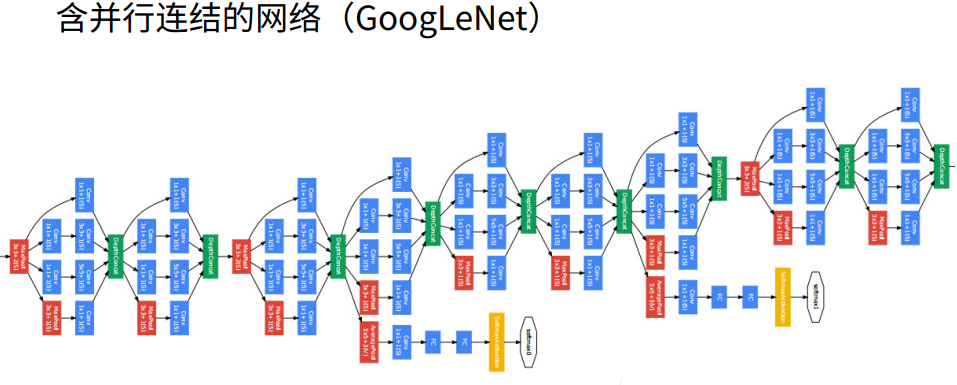

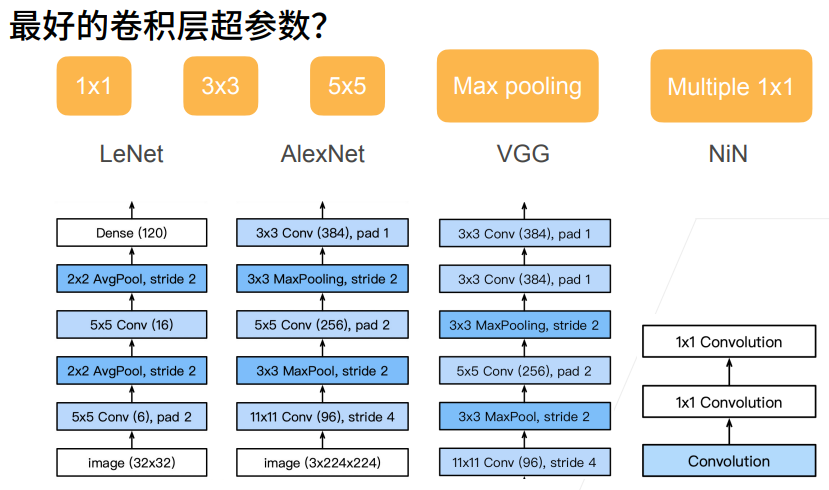

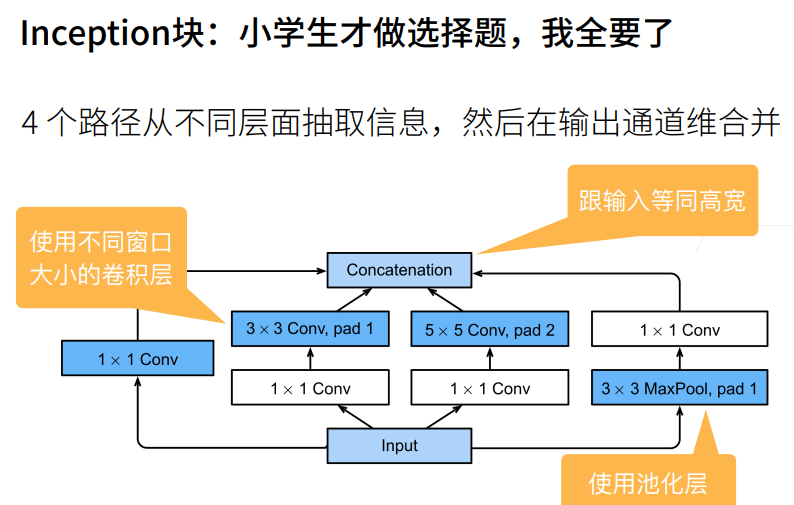

① 白色的卷积用来改变通道数，蓝色的卷积用来抽取信息。

② 最左边一条1X1卷积是用来抽取通道信息，其他的3X3卷积用来抽取空间信息。

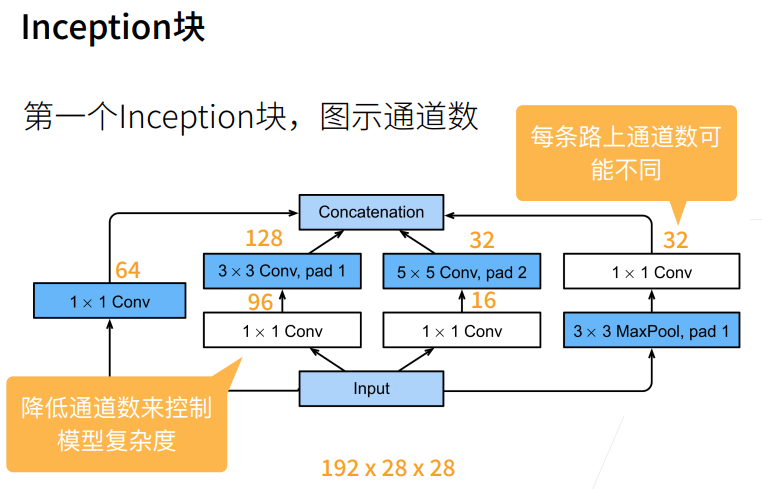

① 输出相同的通道数，5X5比3X3的卷积层参数个数多，3X3比1X1卷积层的参数个数多。

② Inception块使用了大量1X1卷积层，使得参数相对单3X3、5X5卷积层更少。

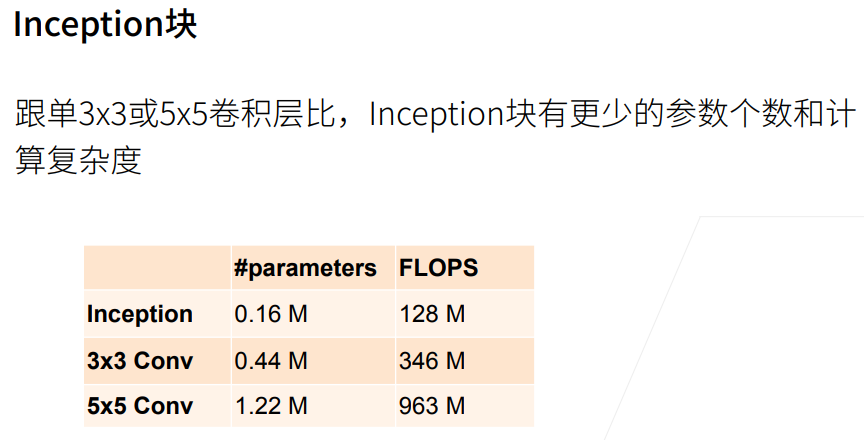

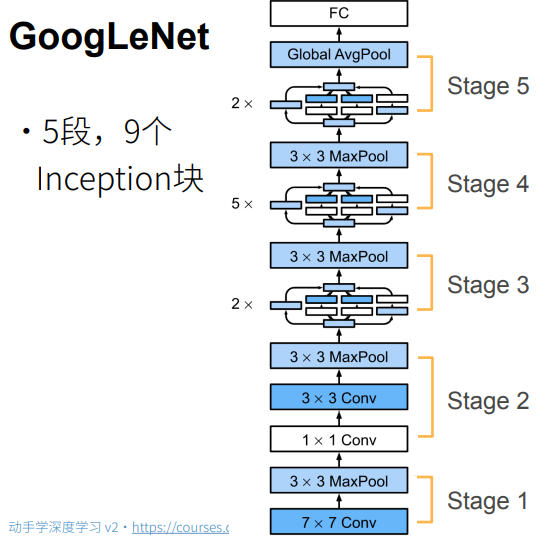

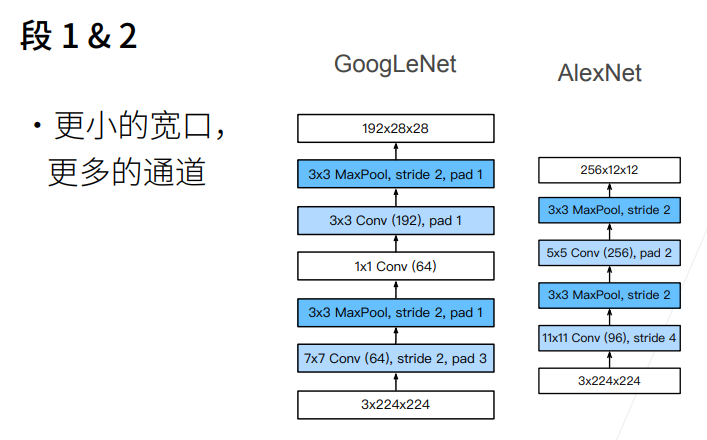

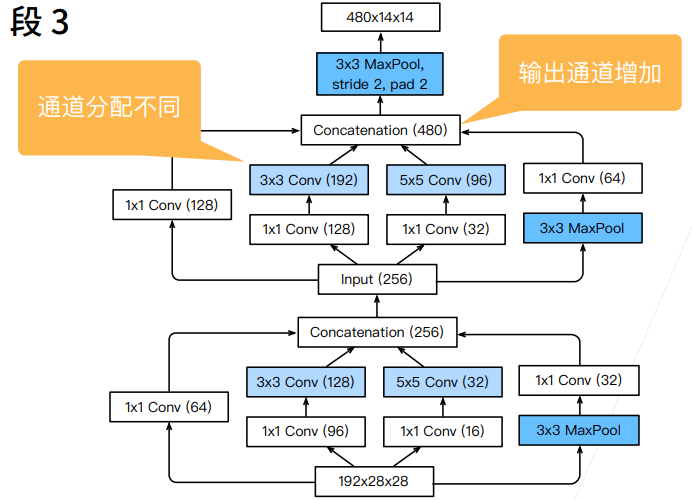

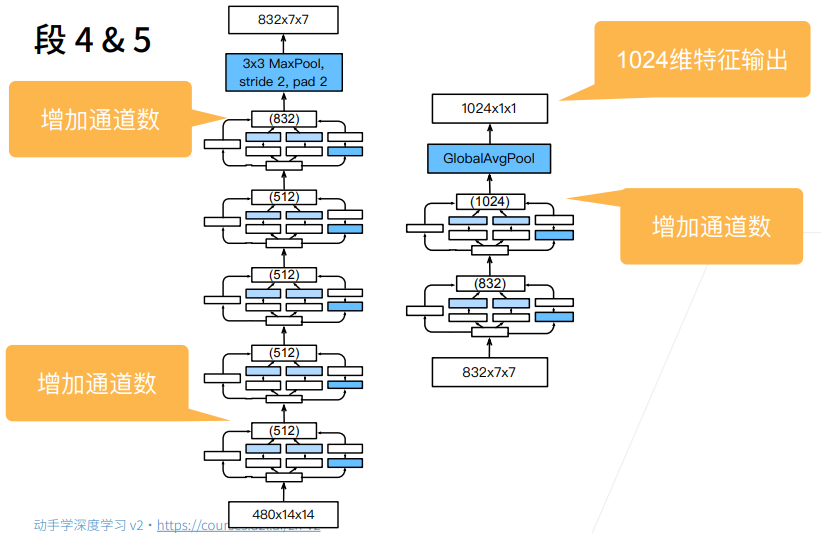

① 1X7卷积层是看行一下空间信息，列信息不看，7X1是列看一下空间信息，行信息不看。

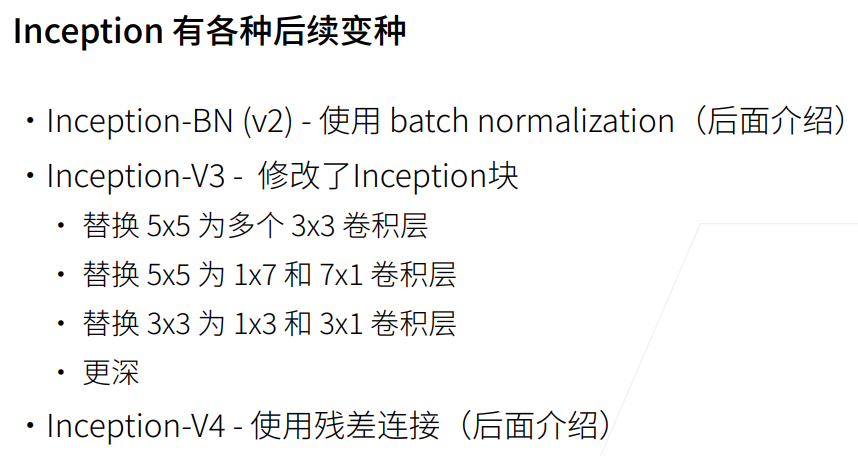

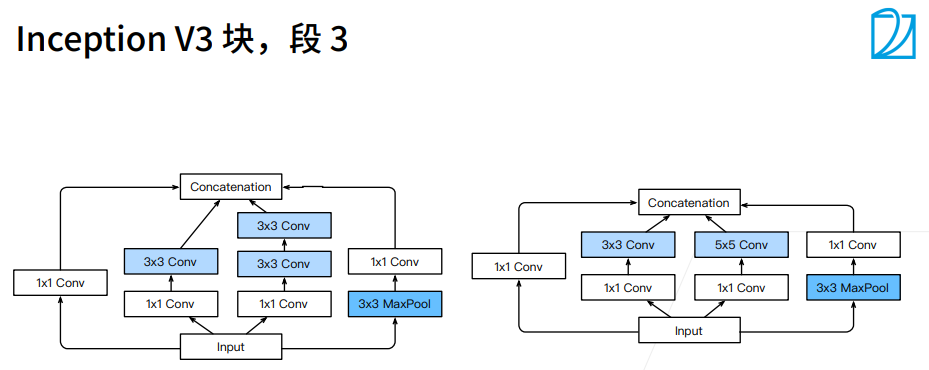

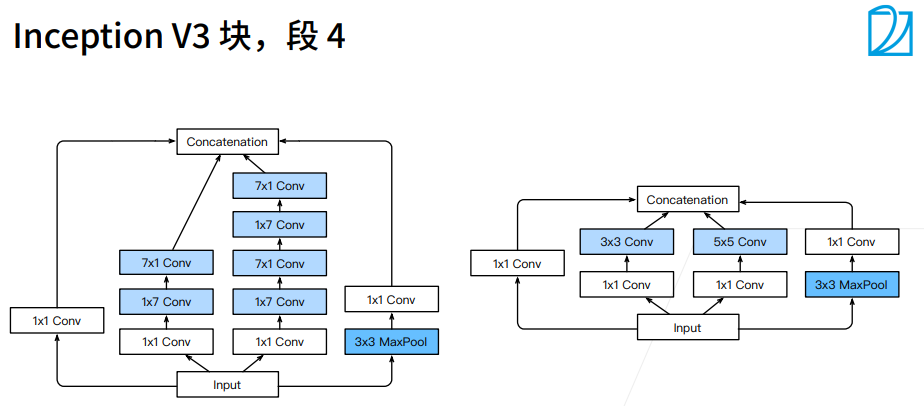

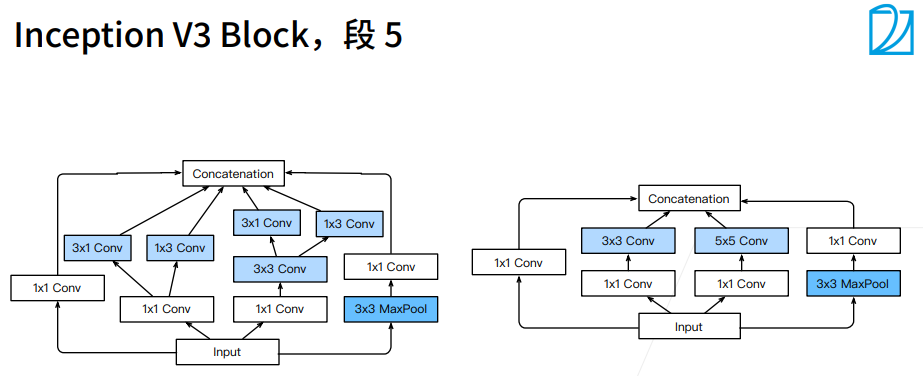

① 圈的大小表示耗内存的大小。

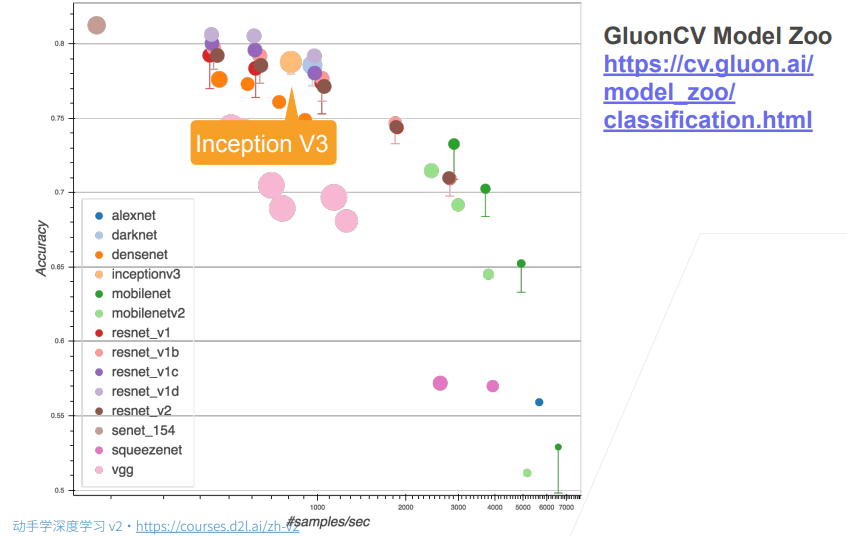

# 2. 总结

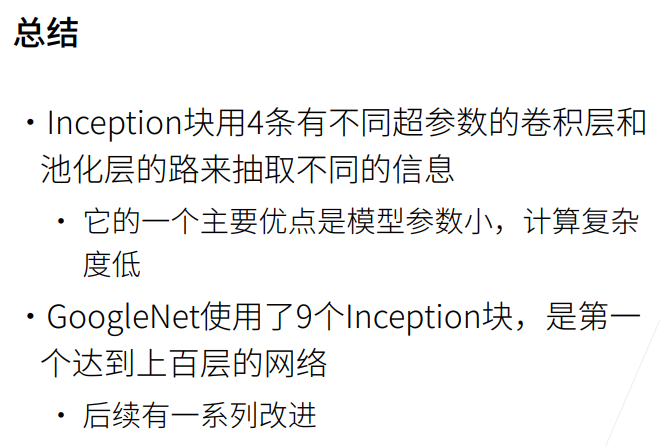

# 1. GoogLeNet（使用自定义）

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): # c1为第一条路的输出通道数、c2为第二条路的输出通道数     
        super(Inception, self).__init__(**kwargs) # python中*vars代表解包元组，**vars代表解包字典，通过这种语法可以传递不定参数。**kwage是将除了前面显式列出的参数外的其他参数, 以dict结构进行接收.                                                    
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels,c4,kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))  # 第一条路的输出
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x)))) # 第二条路的输出
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1) # 批量大小的dim为0，通道数的dim为1，以通道数维度进行合并

In [2]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                  nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))  

b2 = nn.Sequential(nn.Conv2d(64,64,kernel_size=1),nn.ReLU(),
                  nn.Conv2d(64,192,kernel_size=3,padding=1),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

b3 = nn.Sequential(Inception(192,64,(96,128),(18,32),32),
                  Inception(256,128,(128,192),(32,96),64),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

b4 = nn.Sequential(Inception(480,192,(96,208),(16,48),64),
                  Inception(512,160,(112,224),(24,64),64),
                  Inception(512,128,(128,256),(24,64),64),
                  Inception(512,112,(144,288),(32,64),64),
                  Inception(528,256,(160,320),(32,128),128),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

b5 = nn.Sequential(Inception(832,256,(160,320),(32,128),128),
                   Inception(832,384,(192,384),(48,128),128),
                  nn.AdaptiveAvgPool2d((1,1)),nn.Flatten())

net = nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

① 在实际的项目当中，我们往往预先只知道的是输入数据和输出数据的大小，而不知道核与步长的大小。

② 我们可以手动计算核的大小和步长的值。而自适应（Adaptive）能让我们从这样的计算当中解脱出来，只要我们给定输入数据和输出数据的大小，自适应算法能够自动帮助我们计算核的大小和每次移动的步长。

③ 相当于我们对核说，我已经给你输入和输出的数据了，你自己适应去吧。你要长多大，你每次要走多远，都由你自己决定，总之最后你的输出符合我的要求就行了。

④ 比如我们给定输入数据的尺寸是9， 输出数据的尺寸是3，那么自适应算法就能自动帮我们计算出，核的大小是3，每次移动的步长也是3，然后依据这些数据，帮我们创建好池化层。

In [3]:
help(nn.AdaptiveAvgPool2d) # 对输入应用自适应平均池化，将feature map改为我们需要大小的输出。只需要给定输出特征图的大小就好，其中通道数前后不发生变化。                    

Help on class AdaptiveAvgPool2d in module torch.nn.modules.pooling:

class AdaptiveAvgPool2d(_AdaptiveAvgPoolNd)
 |  Applies a 2D adaptive average pooling over an input signal composed of several input planes.
 |  
 |  The output is of size H x W, for any input size.
 |  The number of output features is equal to the number of input planes.
 |  
 |  Args:
 |      output_size: the target output size of the image of the form H x W.
 |                   Can be a tuple (H, W) or a single H for a square image H x H.
 |                   H and W can be either a ``int``, or ``None`` which means the size will
 |                   be the same as that of the input.
 |  
 |  Shape:
 |      - Input: :math:`(N, C, H_{in}, W_{in})` or :math:`(C, H_{in}, W_{in})`.
 |      - Output: :math:`(N, C, S_{0}, S_{1})` or :math:`(C, S_{0}, S_{1})`, where
 |        :math:`S=\text{output\_size}`.
 |  
 |  Examples:
 |      >>> # target output size of 5x7
 |      >>> m = nn.AdaptiveAvgPool2d((5,7))
 |      >>> in

In [4]:
# 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96
X = torch.rand(size=(1,1,96,96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
                                           padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

loss 0.252, train acc 0.903, test acc 0.889
1518.0 examples/sec on cuda:0


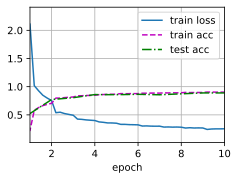

In [6]:
lr, num_epochs, batch_size =0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)  
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())